# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy import sparse, signal, stats
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
from sunpy.coordinates import HeliographicStonyhurst, Helioprojective, Heliocentric
%matplotlib inline

### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

## Define functions to find files

In [6]:
def _deltaDate(date, ndays):
    """
    Function that returns a date object shifted by a number of days for vectorization

    :param date: date to shift
    :param ndays: Number of days in the timedelta
    :return:  timedelta
    """    
    return date+datetime.timedelta(days=float(ndays))

def searchMagnetograms(date, dtol=1, nresults=1, instrument='MDI', mtwilsonl='0fe'):
    """
    Function that looks for the closest observation to a date for a given instrument

    :param dateStr: datetime object
    :param dtol: number of dates of tolerance for the search
    :param nresults: top number of matches to return.  0 Returns all
    :param instrument: Text indicating the instrument that will be used in the search
    :param mtwilsonl: Which line to use for magnetograms in the later Mt. Wilson Period post 1995 
    :return:  Pandas dataframe with the paths, the dates, and the time difference.
              If there is no match, the pandas dataframe is returned empty
    """
    
    print('Searching for closest', nresults, instrument, 'results within', dtol, 'days of' , date, '...', flush=True)

    # Dictionary with buckets
    buckets = {'512': 'fdl-mag-512',
               'MDI': 'fdl-mag-mdi',
               'MWO': 'fdl-mag-mt-wilson',
               'HMI': 'fdl-mag-sdo',
               'SPMG': 'fdl-mag-spmg',
               'SOLIS': 'fdl-mag-solis',
               'SOT': 'fdl-mag-sot'}
    
    # First day of the MDI mission
    MDIdate0 = datetime.datetime.fromisoformat('1993-01-01T00:00:00')    
    
    # Vectorize time shift function
    deltaDateV = np.vectorize(_deltaDate)
    # Find search range in days
    dateRange = deltaDateV(date, np.arange(-dtol, dtol+1))
    # Create dataframe for holding results
    closestFiles = pd.DataFrame(columns=['Path', 'Date', 'TimeDif', 'AbsTimeDif'])    
    
    # Connect to bucket
    bucket = client.get_bucket(buckets[instrument])
       
    for dateCheck in dateRange:
        
        if instrument == '512':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)
            
            path = Yr[2:4] + Mo + '/'
            blobs = bucket.list_blobs(prefix=path)  

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if Yr+Mo+Dy in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos+1:tmpPos+3])
                    mn = int(blob.name[tmpPos+3:tmpPos+5])
                    sc = 0

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)
           
        
        if instrument == 'MDI':
            
            # Find files for range
            mdiDate = dateCheck.toordinal() - MDIdate0.toordinal()
            fileID = 'fd_M_96m_01d.' + str(mdiDate) + '.00' 
            path = str(dateCheck.year) + '/fd_M_96m_01d.00' + str(dateCheck.toordinal() - MDIdate0.toordinal() ) + '/'
            blobs = bucket.list_blobs(prefix=path)    

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if fileID in blob.name:

                    # Extract file number
                    tmpPos = blob.name.rfind(str(mdiDate))
                    fileNm = int(blob.name[tmpPos+7:tmpPos+9])
                    # Calculate time delta
                    timeDelta = datetime.timedelta(minutes=fileNm*96)
                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day) + timeDelta
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)

                    
        if instrument == 'MWO':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)
            
            path = Yr + '/' + Mo + '/' + Dy + '/'
            blobs = bucket.list_blobs(prefix=path)               

            
            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if 'P00' in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos+1:tmpPos+3])-1
                    mn = int(blob.name[tmpPos+3:tmpPos+5])
                    sc = 0
                    
                    # Fix Times
                    if mn>59:
                        mn = mn-60
                        hr = hr+1
                    
                    # Assemble date
                    if hr>23:
                        tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr-24, mn, sc)+datetime.timedelta(days=1)
                    else:
                        tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)            
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)
                    
                # If one of the magnetograms is found
                if mtwilsonl in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos-4:tmpPos-2])-1
                    mn = int(blob.name[tmpPos-2:tmpPos])
                    sc = 0
                    
                    # Fix Times
                    if mn>59:
                        mn = mn-60
                        hr = hr+1
                    
                    # Assemble date
                    if hr>23:
                        tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr-24, mn, sc)+datetime.timedelta(days=1)
                    else:
                        tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)                    
                    
                    
        if instrument == 'HMI':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)
            
            path = Yr + '/' + Mo + '/' + Dy + '/'
            blobs = bucket.list_blobs(prefix=path)               

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if 'magnetogram.fits' in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos-6:tmpPos-4])
                    mn = int(blob.name[tmpPos-4:tmpPos-2])
                    sc = int(blob.name[tmpPos-2:tmpPos])

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)

                    
        if instrument == 'SPMG':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)
            
            path = Yr[2:4] + Mo + '/'
            blobs = bucket.list_blobs(prefix=path)  

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if Yr+Mo+Dy in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos+1:tmpPos+3])
                    mn = int(blob.name[tmpPos+3:tmpPos+5])
                    sc = 0

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)
                    
                    
        if instrument == 'SOLIS':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)


            # Looping through versions        
            for v in range(1,6):        

                # Find files for range
                path = Yr + Mo + '/k' + str(v) + 'v93' + Yr[2:4] + Mo + Dy + '/'
                blobs = bucket.list_blobs(prefix=path)    

                # Scan Blobs
                for blob in blobs:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos-6:tmpPos-4])
                    mn = int(blob.name[tmpPos-4:tmpPos-2])
                    sc = int(blob.name[tmpPos-2:tmpPos])

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)
                    
                    
        if instrument == 'SOT':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)
            
            path = Yr + '/' + Mo + '/' + Dy + '/SP3D/'
            blobs = bucket.list_blobs(prefix=path)               

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if '.fits' in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos+1:tmpPos+3])
                    mn = int(blob.name[tmpPos+3:tmpPos+5])
                    sc = int(blob.name[tmpPos+5:tmpPos+7])

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)                    
                    
                             
    if closestFiles.shape[0] == 0:
        print('done. No', instrument, 'file found.', flush=True)
    else:
        print('done.', flush=True)
    print(' ', flush=True)
    
    # Sort according to time difference
    closestFiles = closestFiles.sort_values(by=['AbsTimeDif']).reset_index(drop=True)
    
    # Return all observations with 0 or a subset
    if nresults == 0:
        return closestFiles
    else:
        return closestFiles.loc[0:nresults-1,:]
    
    
def applyDiffRot(magMap, endDate, method='linear'):
    """
    Function that rotates a map differentially from a given date to another

    :param magMap: Map with the magnetogram that will be rotated
    :param endDate: Final date after rotation
    :param method: interpolation method
    :return: Differentially rotated map with new date-obs parameter.
    """
    
    endDate = Time(endDate)
    
    ## Apply differential rotation
    x, y = np.meshgrid(*[np.arange(v.value) for v in magMap.dimensions]) * u.pixel
    hpc_coords = magMap.pixel_to_world(x, y)
    newcoords = dr.solar_rotate_coordinate(hpc_coords, time = endDate)

    # Flatten
    x2 = newcoords.Tx.flatten()
    y2 = newcoords.Ty.flatten()
    x1 = hpc_coords.Tx.flatten()
    y1 = hpc_coords.Ty.flatten()
    old_mg = magMap.data.flatten()
    dim1 = magMap.dimensions

    # Make sure it only operates on finite pixels
    ind = (np.isfinite(x1) * np.isfinite(y1) * np.isfinite(x2) * np.isfinite(y2) * np.isfinite(old_mg))

    # Interpolate into new  position
    interp_data = griddata((x2[ind], y2[ind]), old_mg[ind], (x1[ind], y1[ind]), method=method)
    new_mg = np.full((int(dim1[0].value), int(dim1[1].value)), np.nan)
    new_mg.ravel()[ind] = interp_data

    # Create map    
    magMap.meta['DATE-OBS'] = endDate.strftime('%Y-%m-%dT%H:%M:%S')
    magMap.meta['DATE_OBS'] = endDate.strftime('%Y-%m-%dT%H:%M:%S')

    # Assemble Sunpy map
    return sunpy.map.Map(new_mg, magMap.meta)   

In [7]:
# dateStr = '2011-04-01T00:20:00'  # Most simultaneous instruments

# Differential rotation variables
# Flag
DR_sw = False
# Method
DRmethod = 'linear'

# Initialize field of view:
FoV_BL_coord = []
FoV_TR_coord = []

# Initialize Radius for changing MDI's perspective:
RSUN_OBS = []

## Read SDO/HMI

In [8]:
dateStr = '2011-01-04T00:00:00'  # Sun at perihelion
# dateStr = '2010-07-07T00:00:00'  # Sun at Aphelion
searchDate = datetime.datetime.fromisoformat(dateStr)

bestMatchHMI = searchMagnetograms(searchDate, instrument='HMI')
if bestMatchHMI.shape[0] > 0:
    print('Loading Fits File...', flush=True)
    bucket = client.get_bucket('fdl-mag-sdo')
    blob = storage.Blob(bestMatchHMI.loc[0,'Path'], bucket)

    blob.download_to_filename('/tmp/tempHMI.fits')

    HMI_fits = fits.open('/tmp/tempHMI.fits', cache=False)
    HMI_fits.verify('fix')
    dataHMI = HMI_fits[1].data
    
    # Assemble Sunpy map
    HMImapNS = sunpy.map.Map(HMI_fits[1].data, HMI_fits[1].header)
    
    scalex = HMImapNS.meta['cdelt1']
    scaley = HMImapNS.meta['cdelt2']
    
    ratio = HMImapNS.meta['DSUN_OBS']/HMImapNS.meta['DSUN_REF'] 
        
    # Fix instrument rotation and upscale
    rot_map = HMImapNS.rotate(scale=ratio, angle = HMI_fits[1].header['CROTA2']*u.deg, missing=np.nan, recenter=True)
    HMI_fits.close()
        
    # Want image the same size as original so use dimension from input map
    x_scale = ((rot_map.scale.axis1 * HMImapNS.dimensions.x) / 2)
    y_scale = ((rot_map.scale.axis2 * HMImapNS.dimensions.y) / 2)

    # Define coordinates
    bottom_left = SkyCoord(-x_scale, -y_scale, frame=rot_map.coordinate_frame)
    top_right = SkyCoord(x_scale, y_scale, frame=rot_map.coordinate_frame)

    HMImap = rot_map.submap(bottom_left, top_right) 
    
    # Update Meta
    HMImap.meta['rsun_obs'] = HMImap.meta['rsun_obs']*ratio
    HMImap.meta['cdelt1'] = scalex
    HMImap.meta['cdelt2'] = scaley
    HMImap.meta['dsun_obs'] = HMImap.meta['dsun_ref']

    # Apply NaNs for Pixels outside the Sun
    x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
    hpc_coords = HMImap.pixel_to_world(x, y)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs
#     HMImap.data[r>1] = np.nan
    
    print('done.', flush=True)
    print(' ', flush=True)
    
    # HMI map at 1AU
    HMI_PH = HMImap
    print('Rsun_Obs', HMI_PH.meta['rsun_obs'])
    print('Dsun_Obs',HMI_PH.meta['dsun_obs'])
    

Searching for closest 1 HMI results within 1 days of 2011-01-04 00:00:00 ...
done.
 
Loading Fits File...


 [astropy.io.fits.verify]


done.
 
Rsun_Obs 959.6449448210383
Dsun_Obs 149597870691


## Read SOHO/MDI but combining the removal of the Earth's orbit with the rescaling to HMI

In [32]:
bestMatchMDI = searchMagnetograms(searchDate, instrument='MDI')
if bestMatchMDI.shape[0] > 0:
    print('Loading Fits File...', flush=True)
    bucket = client.get_bucket('fdl-mag-mdi')
    blob = storage.Blob(bestMatchMDI.loc[0,'Path'], bucket)

    blob.download_to_filename('/tmp/tempMDI.fits')
    MDI_fits = fits.open('/tmp/tempMDI.fits', cache=False)
    MDI_fits.verify('fix')
    
    # Adding missing header information
    headerMDI = MDI_fits[0].header
    headerMDI['RSUN_OBS'] = headerMDI['OBS_R0']
    headerMDI['RSUN_REF'] = 696000000
    headerMDI['CROTA2'] = -headerMDI['SOLAR_P0']
    headerMDI['CRVAL1'] = 0.000000
    headerMDI['CRVAL2'] = 0.000000
    headerMDI['CUNIT1'] = 'arcsec'
    headerMDI['CUNIT2'] = 'arcsec'
    headerMDI['DSUN_OBS'] = headerMDI['OBS_DIST']
    headerMDI['DSUN_REF'] = 1

    headerMDI.pop('SOLAR_P0')
    headerMDI.pop('OBS_DIST')
    headerMDI.pop('OBS_R0')
    headerMDI.pop('im_scale')
    headerMDI.pop('fd_scale')
    headerMDI.pop('xscale')
    headerMDI.pop('yscale')

    
    # Assemble Sunpy map
    MDImapNS = sunpy.map.Map(MDI_fits[0].data, headerMDI)

    scalex = MDImapNS.meta['cdelt1']
    scaley = MDImapNS.meta['cdelt2']
    
    ratio_dis = MDImapNS.meta['DSUN_OBS']
    ratio_plate = np.round(MDImapNS.meta['cdelt1']/HMI_PH.meta['cdelt1'])*HMI_PH.meta['cdelt1']/MDImapNS.meta['cdelt1']
    
    # Fix instrument rotation and scale to Earth's perspective
    rot_map = MDImapNS.rotate(scale=ratio_dis/ratio_plate, angle=headerMDI['CROTA2']*u.deg, missing=np.nan, recenter=True)
    MDI_fits.close()
    
#     pprint(rot_map.meta)
        
    # Want image the same size as original so use dimension from input map
    x_scale = ((rot_map.scale.axis1 * MDImapNS.dimensions.x) / 2)
    y_scale = ((rot_map.scale.axis2 * MDImapNS.dimensions.y) / 2)

    # Define coordinates
    bottom_left = SkyCoord(-x_scale, -y_scale, frame=rot_map.coordinate_frame)
    top_right = SkyCoord(x_scale, y_scale, frame=rot_map.coordinate_frame)

#     print(bottom_left,top_right)
    
    MDImap = rot_map.submap(bottom_left, top_right)

    MDImap.meta['cdelt1'] = np.round(MDImapNS.meta['cdelt1']/HMI_PH.meta['cdelt1'])*HMI_PH.meta['cdelt1']
    MDImap.meta['cdelt2'] = np.round(MDImapNS.meta['cdelt1']/HMI_PH.meta['cdelt1'])*HMI_PH.meta['cdelt1']
    MDImap.meta['DSUN_OBS'] = 1 
    MDImap.meta['rsun_obs'] = MDImap.meta['rsun_obs']*ratio_dis  
    
    # Apply NaNs for Pixels outside the Sun
    x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
    hpc_coords = MDImap.pixel_to_world(x, y)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
#     MDImap.data[r>1] = np.nan
    
    MDI_PH = MDImap
    
    print('done.', flush=True)
    print(' ', flush=True)

Searching for closest 1 MDI results within 1 days of 2011-01-04 00:00:00 ...
done.
 
Loading Fits File...


('obs_l0', 'obs_b0', 'obs_dist')
('hgln_obs', 'hglt_obs', 'dsun_obs')
('crln_obs', 'crlt_obs', 'dsun_obs') [sunpy.map.mapbase]


done.
 


In [18]:
# bestMatchMDI = searchMagnetograms(searchDate, instrument='MDI')
# if bestMatchMDI.shape[0] > 0:
#     print('Loading Fits File...', flush=True)
#     bucket = client.get_bucket('fdl-mag-mdi')
#     blob = storage.Blob(bestMatchMDI.loc[0,'Path'], bucket)

#     blob.download_to_filename('/tmp/tempMDI.fits')
#     MDI_fits = fits.open('/tmp/tempMDI.fits', cache=False)
#     MDI_fits.verify('fix')
    
#     # Adding missing header information
#     headerMDI = MDI_fits[0].header
#     headerMDI['RSUN_REF']= 696000000
#     headerMDI['CROTA2'] = -headerMDI['SOLAR_P0']
#     headerMDI['CRVAL1']  = 0.000000                                                              
#     headerMDI['CRVAL2']  = 0.000000
#     headerMDI['CUNIT1']  = 'arcsec'                                                              
#     headerMDI['CUNIT2']  = 'arcsec'
#     headerMDI['rsun_obs'] = headerMDI['OBS_R0']
#     headerMDI['crpix1'] = headerMDI['crpix1'] - MDI_fits[0].data.shape[0]/2 + HMI_PH.data.shape[0]/2
#     headerMDI['crpix2'] = headerMDI['crpix2'] - MDI_fits[0].data.shape[1]/2 + HMI_PH.data.shape[1]/2

    
#     # Create new Field of View based on HMI
#     new_fov = HMI_PH.data*np.nan
    
#     # Identify the indices for appending the MDI original FoV
#     i1 = int(HMI_PH.data.shape[0]/2-MDI_fits[0].data.shape[0]/2+1)
#     i2 = int(HMI_PH.data.shape[0]/2+MDI_fits[0].data.shape[0]/2+1)
    
#     # Insert MDI image into HMI's array
#     new_fov[i1:i2,i1:i2] = MDI_fits[0].data[:,:]
    
#     # Assemble Sunpy map
#     MDImapNS = sunpy.map.Map(new_fov, headerMDI)

#     scalex = HMI_PH.meta['cdelt1']
#     scaley = HMI_PH.meta['cdelt2']
    
#     ratio = MDImapNS.meta['obs_dist']*MDImapNS.meta['cdelt1']/HMI_PH.meta['cdelt1']
        
#     # Fix instrument rotation and scale to Earth's perspective
#     rot_map = MDImapNS.rotate(scale=ratio, angle=-headerMDI['SOLAR_P0']*u.deg, missing=np.nan, recenter=True)
#     MDI_fits.close()
    
# #     pprint(rot_map.meta)
        
#     # Want image the same size as original so use dimension from input map
#     x_scale = ((rot_map.scale.axis1 * HMI_PH.dimensions.x) / 2)
#     y_scale = ((rot_map.scale.axis2 * HMI_PH.dimensions.y) / 2)

#     # Define coordinates
#     bottom_left = SkyCoord(-x_scale, -y_scale, frame=rot_map.coordinate_frame)
#     top_right = SkyCoord(x_scale, y_scale, frame=rot_map.coordinate_frame)

# #     print(bottom_left,top_right)
    
#     MDImap = rot_map.submap(bottom_left, top_right)

#     MDImap.meta['cdelt1'] = scalex
#     MDImap.meta['cdelt2'] = scaley
#     MDImap.meta['obs_dist'] = 1 
#     MDImap.meta['rsun_obs'] = HMI_PH.meta['rsun_obs']   
#     MDImap.meta['OBS_R0'] = HMI_PH.meta['rsun_obs']
    
#     # Apply NaNs for Pixels outside the Sun
#     x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
#     hpc_coords = MDImap.pixel_to_world(x, y)
#     r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
# #     MDImap.data[r>1] = np.nan
    
#     MDI_PH = MDImap
    
#     print('done.', flush=True)
#     print(' ', flush=True)

Searching for closest 1 MDI results within 1 days of 2011-01-04 00:00:00 ...
done.
 
Loading Fits File...


done.
 


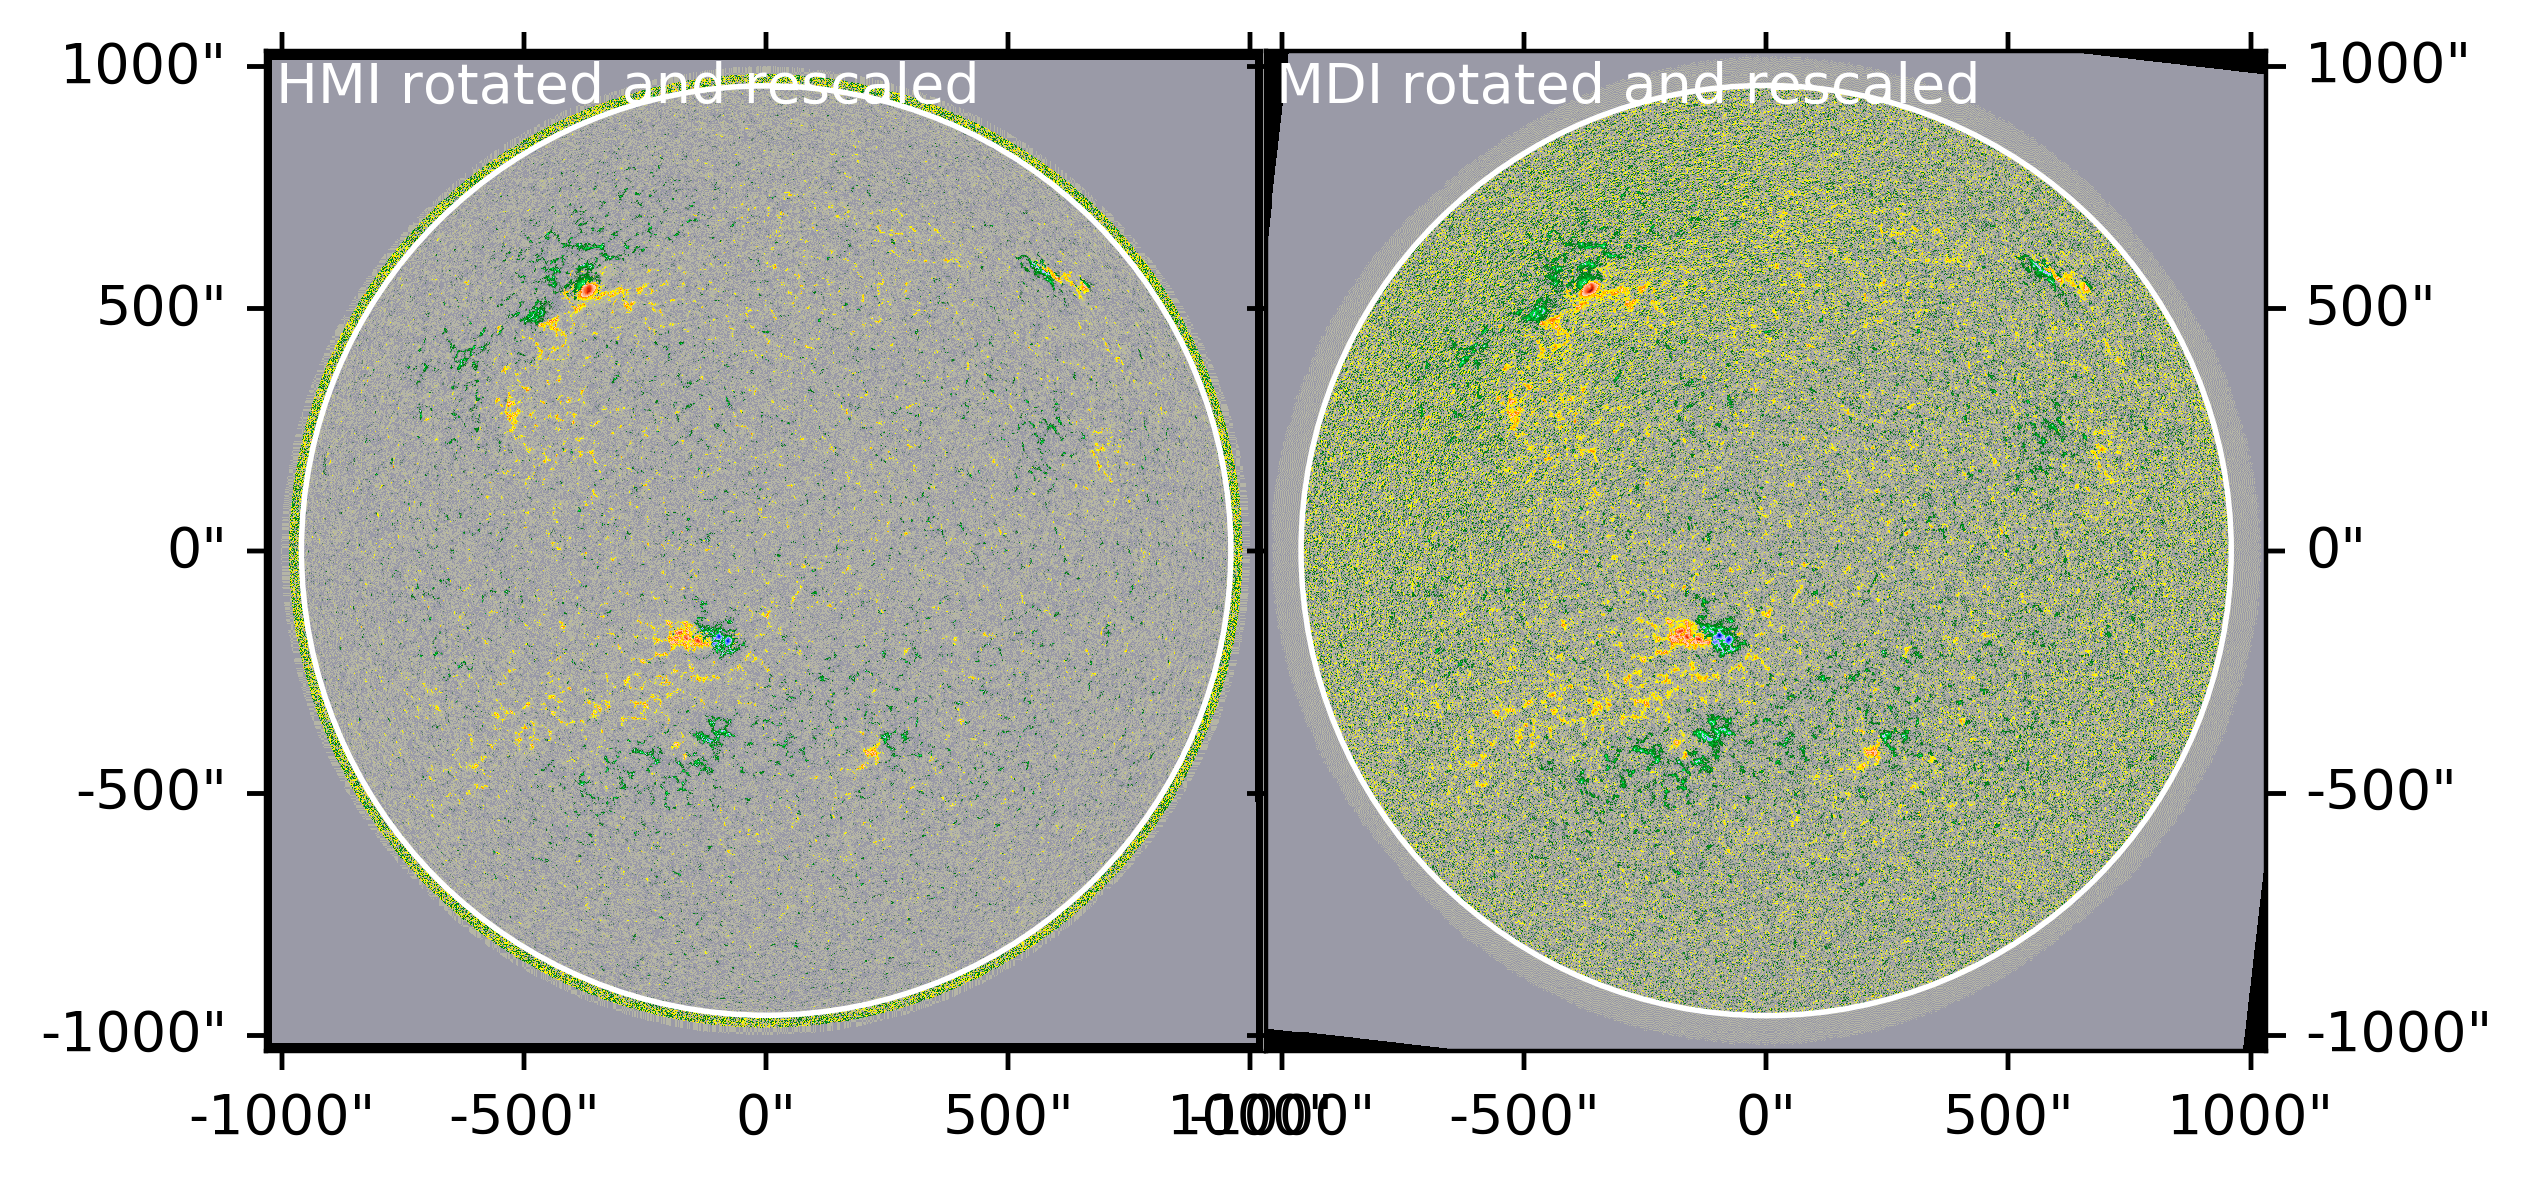

In [33]:
# Size definitions
dpi = 400
pxx = 1000   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 3     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)




## Add Perihelion
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=HMI_PH)

x, y = np.meshgrid(*[np.arange(v.value) for v in HMI_PH.dimensions]) * u.pixel
hpc_coords = HMI_PH.pixel_to_world(x, y)
ax1.pcolormesh(x, y, HMI_PH.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
ax1.grid(False)
HMI_PH.draw_limb()

ax1.text(0.01, 0.99, 'HMI rotated and rescaled', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax1.transAxes)


## MDI
ax2 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy], projection=MDI_PH)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDI_PH.dimensions]) * u.pixel
hpc_coords = MDI_PH.pixel_to_world(x, y)
mesh = ax2.pcolormesh(x, y, MDI_PH.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

ax2.grid(False)

ax2.text(0.01, 0.99, 'MDI rotated and rescaled', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax2.transAxes)
MDI_PH.draw_limb()



lat = ax2.coords[1]
lat.set_ticklabel_position('r')



# ## Add Perihelion
# ax3 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy], projection=HMImapNS)

# x, y = np.meshgrid(*[np.arange(v.value) for v in HMImapNS.dimensions]) * u.pixel
# hpc_coords = HMImapNS.pixel_to_world(x, y)
# ax3.pcolormesh(x, y, HMImapNS.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax3.grid(False)
# HMImapNS.draw_limb()

# ax3.text(0.01, 0.99, 'HMI Raw', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax3.transAxes)


# lon = ax3.coords[0]
# lon.set_ticklabel_position('t')


# ## MDI
# ax4 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy], projection=MDImapNS)

# x, y = np.meshgrid(*[np.arange(v.value) for v in MDImapNS.dimensions]) * u.pixel
# hpc_coords = MDImapNS.pixel_to_world(x, y)
# mesh = ax4.pcolormesh(x, y, MDImapNS.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

# ax4.grid(False)

# ax4.text(0.01, 0.99, 'MDI Raw', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax4.transAxes)
# MDImapNS.draw_limb()


# lon = ax4.coords[0]
# lon.set_ticklabel_position('t')

# lat = ax4.coords[1]
# lat.set_ticklabel_position('r')

In [34]:
plt.close(fig)

## Crop to arbitrary submap

In [44]:
arcs = 100*HMI_PH.meta['cdelt1']

bottom_left_coord = SkyCoord(-arcs*u.arcsec, -arcs*u.arcsec, frame=HMI_PH.coordinate_frame)
top_right_coord = SkyCoord(arcs*u.arcsec, arcs*u.arcsec, frame=HMI_PH.coordinate_frame)
smHMI = HMI_PH.submap(bottom_left_coord,top_right_coord)

bottom_left_coord = SkyCoord(-arcs*u.arcsec, -arcs*u.arcsec, frame=MDI_PH.coordinate_frame)
top_right_coord = SkyCoord(arcs*u.arcsec, arcs*u.arcsec, frame=MDI_PH.coordinate_frame)
smMDIraw = MDI_PH.submap(bottom_left_coord,top_right_coord)

print('HMI submap dimensions',smHMI.dimensions)
print('MDI submap dimensions',smMDIraw.dimensions)

HMI submap dimensions PixelPair(x=<Quantity 200. pix>, y=<Quantity 200. pix>)
MDI submap dimensions PixelPair(x=<Quantity 50. pix>, y=<Quantity 50. pix>)


('obs_l0', 'obs_b0', 'obs_dist')
('hgln_obs', 'hglt_obs', 'dsun_obs')
('crln_obs', 'crlt_obs', 'dsun_obs') [sunpy.map.mapbase]


396.6105661020915

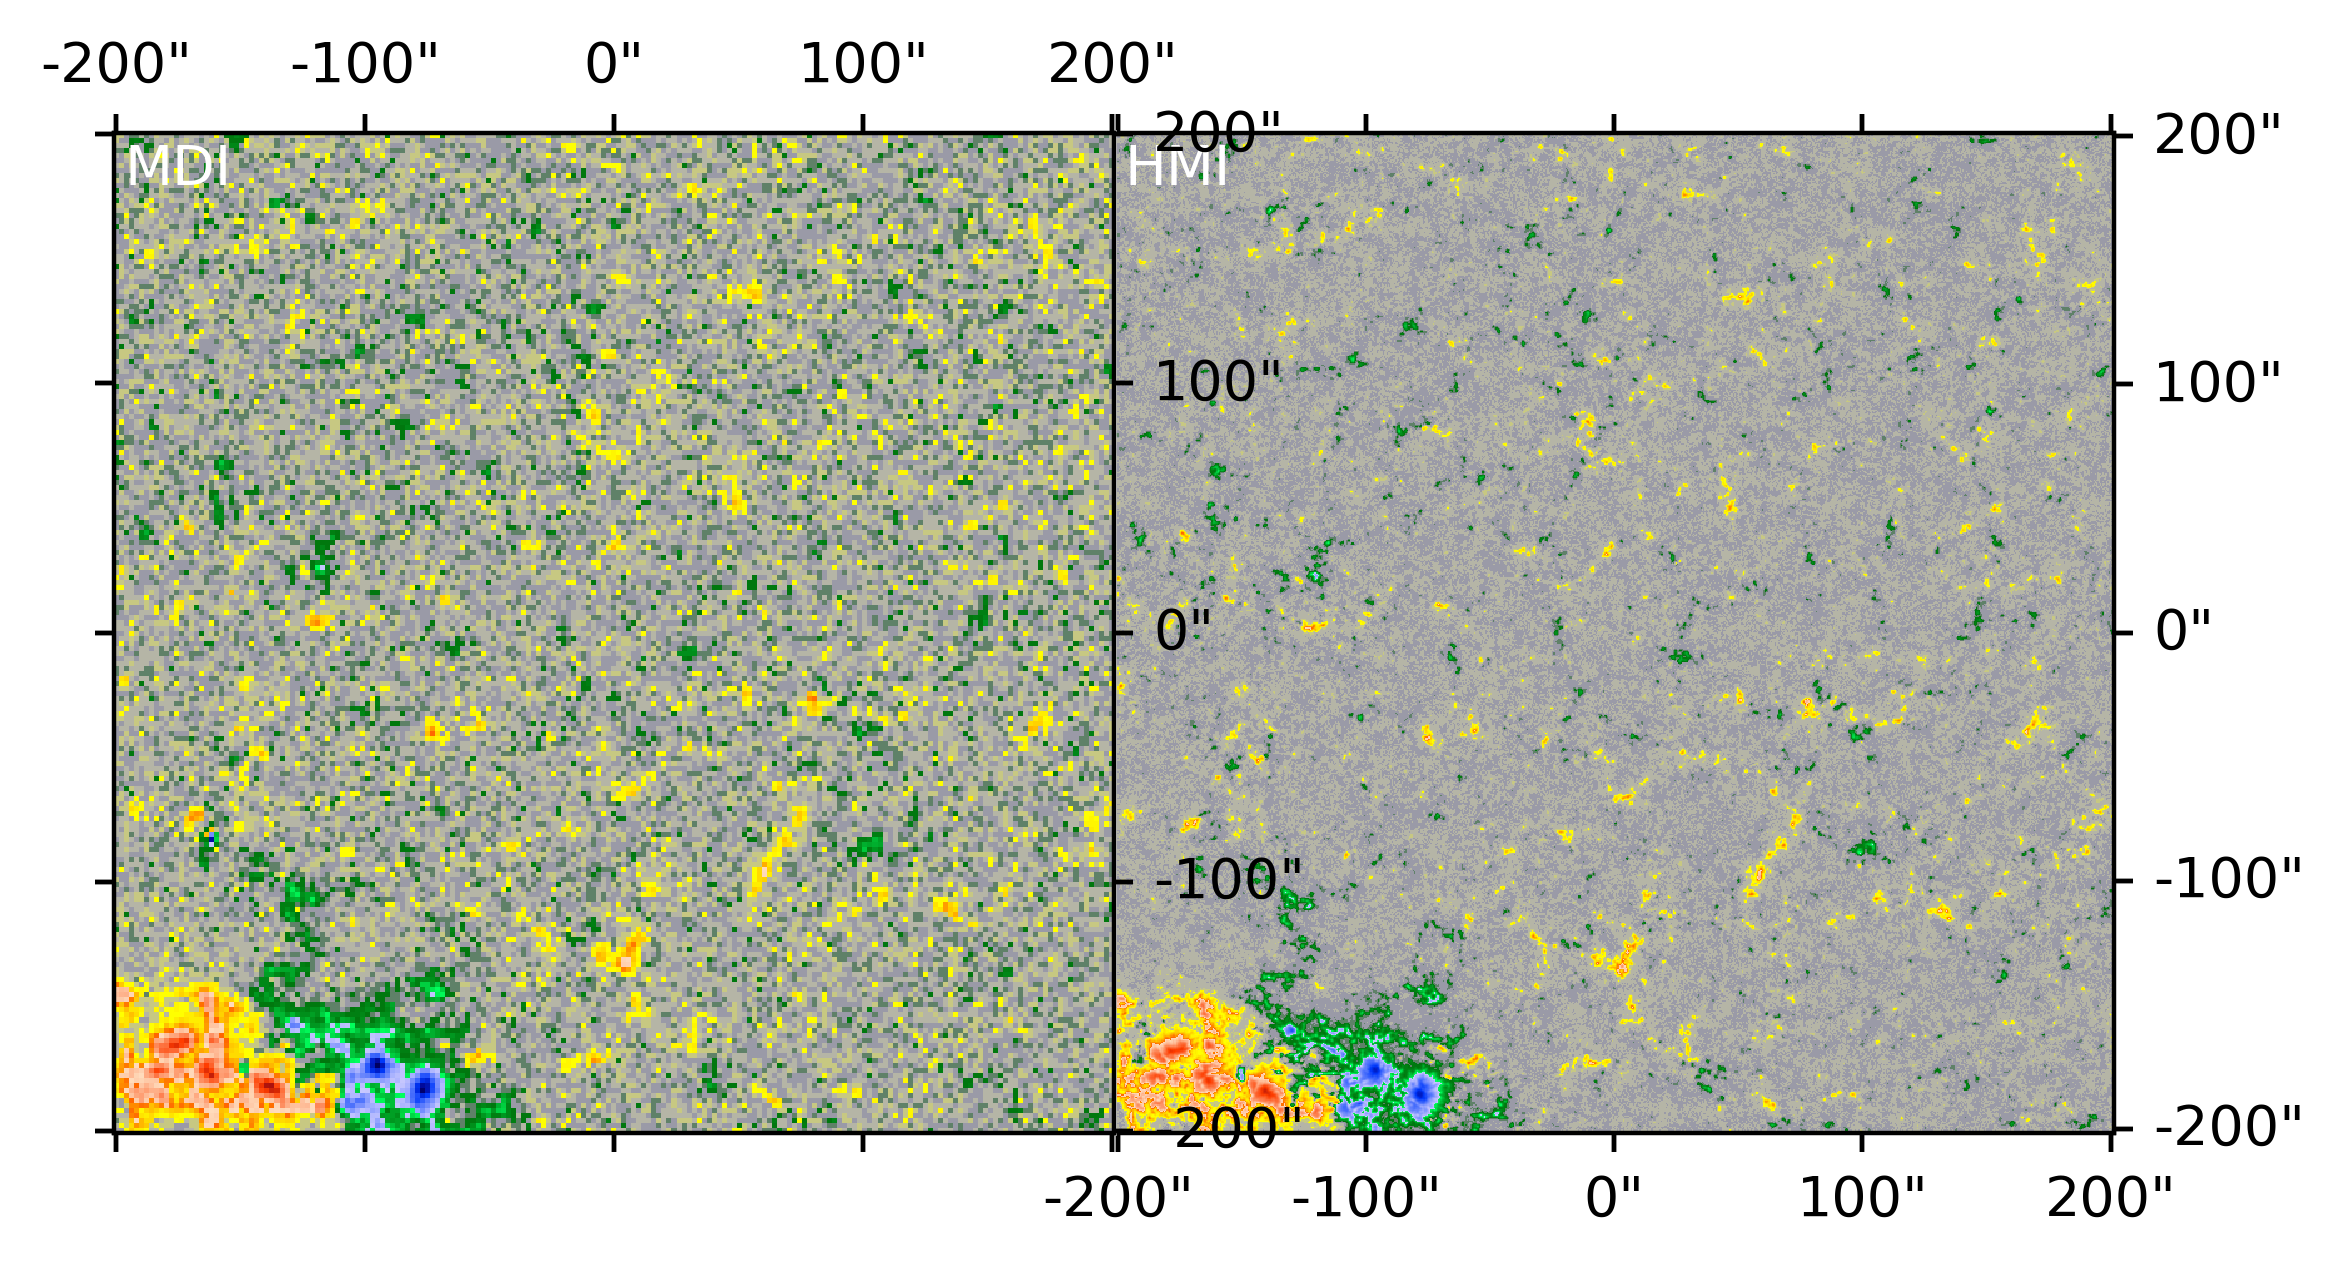

In [40]:
# Size definitions
dpi = 400
pxx = 1000   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 2     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# diff_cmap = plt.cm.get_cmap('seismic')

# Difference
# ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=smHMI)

# x, y = np.meshgrid(*[np.arange(v.value) for v in smHMI.dimensions]) * u.pixel
# hpc_coords = smHMI.pixel_to_world(x, y)
# ax1.pcolormesh(x, y, smHMI.data-smMDIraw.data, vmin=vmin, vmax=vmax, cmap = diff_cmap)
# ax1.grid(False)
# mdi2hmi_mapLL.draw_limb()

# ax1.text(0.01, 0.99, 'Difference', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax1.transAxes)


# HMI
ax2 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy], projection=smHMI)

x, y = np.meshgrid(*[np.arange(v.value) for v in smHMI.dimensions]) * u.pixel
hpc_coords = smHMI.pixel_to_world(x, y)
mesh = ax2.pcolormesh(x, y, smHMI.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

ax2.grid(False)

ax2.text(0.01, 0.99, 'HMI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax2.transAxes)
MDI_PH.draw_limb()



lat = ax2.coords[1]
lat.set_ticklabel_position('r')



## MDI
ax4 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy], projection=smMDIraw)

x, y = np.meshgrid(*[np.arange(v.value) for v in smMDIraw.dimensions]) * u.pixel
hpc_coords = smMDIraw.pixel_to_world(x, y)
mesh = ax4.pcolormesh(x, y, smMDIraw.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

ax4.grid(False)

ax4.text(0.01, 0.99, 'MDI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax4.transAxes)
MDI_PH.draw_limb()


lon = ax4.coords[0]
lon.set_ticklabel_position('t')

lat = ax4.coords[1]
lat.set_ticklabel_position('r')



In [41]:
plt.close(fig)